This notebook computes the walking times between census blocks and resource centers

In [3]:
import numpy as np
from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import MultiPoint
import geopandas as gpd
import networkx as nx

In [9]:
import osmnx as ox

Example: Los Angeles County

load data

In [10]:
#loading street network
place = 'Dallas County' #!! replace with desired city here
#G = ox.graph_from_place(place,network_type='walk', buffer_dist = 5000, simplify=False)
G = ox.graph_from_place(place,network_type='walk', simplify=False)

/opt/anaconda3/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/lib/python3.13/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/shapely/set_operations.py:451: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/shapely/set_operations.py:451: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [11]:
groc_sites = gpd.read_file('Dallas/Food access_updated/geo_export_872fcb6c-fbde-4264-ae77-8858a604ed0e.shp' )
census_blocks = gpd.read_file('Dallas/Block/dal_tx_block.shp')

<Axes: >

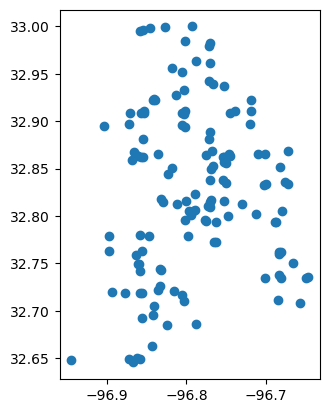

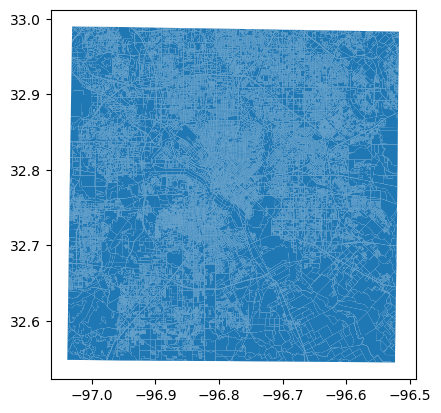

In [12]:
groc_sites.plot()
census_blocks.plot()

In [29]:
groc_sites['geometry'].x

0     -96.788114
1     -96.709663
2     -96.797124
3     -96.750431
4     -96.699660
         ...    
133   -96.800587
134   -96.840205
135   -96.841421
136   -96.729975
137   -96.798062
Length: 138, dtype: float64

In [27]:
crs = {
    'census': 'EPSG:4269'  , # degrees - used by Census
    'projected': 'EPSG:3083',         # projected; needed for maup
    'area'  : 'ESRI:102003', # meters
    'length': 'ESRI:102005', # meters
}
census_blocks['centroid'] = census_blocks.to_crs(crs['projected']).centroid.to_crs(crs['census'])

,geometry,centroid
0,"POLYGON ((-96.55458 32.86208, -96.55382 32.865...",POINT (-96.54631 32.8683)
1,"POLYGON ((-96.54911 32.5907, -96.54893 32.5908...",POINT (-96.54746 32.59116)
2,"POLYGON ((-96.54105 32.90799, -96.54009 32.907...",POINT (-96.54051 32.9079)
3,"POLYGON ((-96.59012 32.88913, -96.58962 32.888...",POINT (-96.57949 32.87981)
4,"POLYGON ((-96.59082 32.74137, -96.59083 32.741...",POINT (-96.58842 32.74067)
...,...,...
38175,"POLYGON ((-96.68292 32.71963, -96.68292 32.719...",POINT (-96.68112 32.71961)
38176,"POLYGON ((-97.01084 32.82374, -97.01062 32.824...",POINT (-97.00945 32.82446)
38177,"POLYGON ((-96.89817 32.88797, -96.89796 32.887...",POINT (-96.89806 32.88458)
38178,"POLYGON ((-96.87919 32.91931, -96.87807 32.919...",POINT (-96.87799 32.91886)


In [28]:
#import pandas as pd
#loading polling-site location
#polls = pd.read_json('Los Angeles/lac_NoCatalina_polls.geojson') #!! specify the path/directory of polls dataset


#nodes=ox.distance.nearest_nodes(G,polls.longitude,polls.latitude)
nodes=ox.distance.nearest_nodes(G,groc_sites['geometry'].x,groc_sites['geometry'].y)
samples=ox.distance.nearest_nodes(G,census_blocks['centroid'].x,census_blocks['centroid'].y)

In [42]:
walk=np.full((len(groc_sites),len(census_blocks)),0)
# walk=np.full((len(groc_sites),10),0)

multiprocess to speed up computation

In [43]:
#get pairs to prepare for multiprocess
pairs_list = []
for i in range(len(nodes)):
    for j in range(len(samples)):
    #for j in range(10):
        pairs_list.append((i,j))

In [44]:
#define function needed for mp
def walk_dist_compute(pair):
    return nx.shortest_path_length(G,nodes[pair[0]],nodes[pair[1]],weight='length')/1.42

In [45]:
if False:
    import multiprocess as mp

    pool = mp.Pool(60)
    distances_list = pool.map(walk_dist_compute, pairs_list)
    pool.close()
else:
    mylist = []
    for p1,p2 in pairs_list:
        print(p1,p2)
        mylist.append(nx.shortest_path_length(G,nodes[p1],nodes[p2],weight='length')/1.42)
        

0 0
0 1
0 2
0 3
0 4


KeyboardInterrupt: 

In [40]:
#reassembling matrix
for i in range(len(pairs_list)):
    walk[pairs_list[i][0],pairs_list[i][1]]=mylist[i]

In [46]:
np.save('dal_groc_census_walk.npy',walk) #name file as desired

In [41]:
walk

array([[    0, 11061, 13258, ..., 24993, 17174, 11739],
       [11061,     0,  8582, ..., 14426, 13937, 11379],
       [13258,  8582,     0, ..., 14337,  6020,  6872],
       ...,
       [ 6273, 12037, 11031, ..., 25146, 12907,  5885],
       [14618,  5654,  5252, ..., 11867, 11085, 11301],
       [15576, 10037,  2428, ..., 13462,  6037,  9013]], shape=(138, 10))